**Install Unsloth for LLM fine-tuning and Initialize base model.**

In [ ]:
%%capture
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
from unsloth import FastLanguageModel
import torch

# Fine-tuning parameters
max_seq_length = 2048
dtype = None
# Use 4bit quantization to reduce memory usage.
load_in_4bit = True

# Dataset format
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
] # More models at https://huggingface.co/unsloth

base_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.9.post4: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

**Running the base model.**

In [ ]:
from transformers import TextStreamer
import re

# Function to extract the response part
def extract_response(generated_text):
    cleaned_text = generated_text.replace("<|end_of_text|>", "")

    match = re.search(r"### Response:\n([\s\S]+)", cleaned_text)

    if match:
        return match.group(1).strip()
    return cleaned_text

**Utilizing LoRA adapter to fine-tune LLM more efficiently and effectively.**

In [ ]:
supervised_model = base_model

supervised_model = FastLanguageModel.get_peft_model(
    supervised_model,
    # ranking number
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.9.post4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


**Prepare customized dataset for improving generated code quality.**

In [ ]:
# Initialize EOS token
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset

dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

train_testvalid = dataset.train_test_split(test_size=0.1, seed=42)

final_datasets = {
    'train': train_testvalid['train'],
    'validation': train_testvalid['test'],
}

print(len(train_testvalid['train']))
print(len(final_datasets['validation']))

README.md:   0%|          | 0.00/905 [00:00<?, ?B/s]

(…)-00000-of-00001-8b6e212f3e1ece96.parquet:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18612 [00:00<?, ? examples/s]

Map:   0%|          | 0/18612 [00:00<?, ? examples/s]

16750
1862


**Start training the LLM**

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = supervised_model,
    tokenizer = tokenizer,
    train_dataset = final_datasets['train'],
    eval_dataset = final_datasets['validation'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        num_train_epochs = 3,
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",

        fp16_full_eval = True,
        per_device_eval_batch_size = 2,
        eval_accumulation_steps = 1,
        eval_strategy = "steps",
        eval_steps = 600,
    ),
)

trainer_stats = trainer.train()

Map (num_proc=2):   0%|          | 0/16750 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1862 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 16,750 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 8
\        /    Total batch size = 32 | Total steps = 1,569
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
600,0.565100,0.543583


Step,Training Loss,Validation Loss
600,0.565100,0.543583
1200,0.434400,0.551661


**Running the fine-tuned model.**

**Save and retrieve the saved model.**

In [ ]:
from google.colab import drive, files
model_name = "supervised_fine_tuned_model"

# Save the model in the drive
if True:
  drive.mount('/content/drive')
  # Save the model to your Drive
  supervised_model.save_pretrained(f"/content/drive/My Drive/Fine_tuned_model/{model_name}")
  tokenizer.save_pretrained(f"/content/drive/My Drive/Fine_tuned_model/{model_name}")

Mounted at /content/drive


In [ ]:
if False:
  # Load the model from your Drive
  from unsloth import FastLanguageModel
  supervised_model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = f"/content/drive/My Drive/Fine_tuned_model/{model_name}",
      max_seq_length = max_seq_length,
      dtype = dtype,
      load_in_4bit = load_in_4bit,
  )

**Load dataset to test LLM's performance**

In [8]:
import json

use_local_dataset = True

test_dataset = {}

if use_local_dataset:
  drive.mount('/content/drive')

  file_path = '/content/drive/My Drive/fine_tune_data_utils/test_dataset_100.json'

  with open(file_path, 'r') as f:
    data = json.load(f)

  for i in range(len(data)):
    test_dataset[i] = data[str(i)]

else:
  test_dataset = load_dataset("flytech/python-codes-25k", split = "train")
  test_dataset = test_dataset.map(formatting_prompts_func, batched = True,)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Test the base LLM model with codeBERT score**

In [1]:
!pip install code-bert-score

  Preparing metadata (setup.py) ... done
  Created wheel for code-bert-score: filename=code_bert_score-0.4.1-py3-none-any.whl size=22071 sha256=fe630067edd66702adfab78362a082b9278155ece0875c9ff05b84de2e892f53
  Stored in directory: /root/.cache/pip/wheels/26/ea/cb/0ddb50c1baacd77c6ea15e3df5862070bee90e7e9bef2150d0
Successfully built code-bert-score


In [10]:
from code_bert_score import score
import matplotlib.pyplot as plt
from code_bert_score import plot_example
import numpy as np
from google.colab import drive, files
import json

# Debug parameter
is_test_dataset_truncated = True
truncated_amount = 100
chosen_dataset = {}

# Generate outputs for the test dataset
is_load_from_local = True
base_test_outputs = []

if is_test_dataset_truncated == True:
  custom_dict = {}
  for i in range(truncated_amount):
    custom_dict[i] = test_dataset[i]
  chosen_dataset = custom_dict
else:
  custom_dict = {}
  for i in range(len(test_dataset)):
    custom_dict[i] = test_dataset[i]
  chosen_dataset = custom_dict

total_output = len(chosen_dataset)

if is_load_from_local == False:
  FastLanguageModel.for_inference(base_model)

# Function to generate outputs for the test dataset
def generate_outputs(dataset, model, tokenizer):
    global current_output
    outputs = []

    for item in dataset.values():
        inputs = tokenizer(
            [alpaca_prompt.format(item['instruction'], item['input'], "")],
            return_tensors="pt"
        ).to("cuda")

        # Generate output from the model
        text_streamer = TextStreamer(tokenizer)
        generated_outputs = model.generate(**inputs, max_new_tokens=max_seq_length)
        generated_text = tokenizer.decode(generated_outputs[0], skip_special_tokens=False)

        response = extract_response(generated_text)

        # Append the generated output to the list
        outputs.append(response)

        current_output +=1
        print(f"Progress: {current_output}/{total_output}")

    return outputs

# Extracting the 'output' field from the test dataset into a separate list
output_field_list = [item["output"] for item in chosen_dataset.values()]

current_output = 0

if is_load_from_local == True:
  drive.mount('/content/drive')

  file_path = '/content/drive/My Drive/fine_tune_data_utils/base_model_test_output.json'

  with open(file_path, 'r') as f:
    data = json.load(f)

  base_test_outputs = data
else:
  base_test_outputs = generate_outputs(chosen_dataset, base_model, tokenizer)

print(base_test_outputs[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
def sum_sequence(nums):
    sum = 0
    for num in nums:
        sum += num
    return sum

nums = [1, 2, 3, 4, 5]
result = sum_sequence(nums)
print(result)


**Save base model output into local device**

In [ ]:
# Save base model test ouput
if False:
  drive.mount('/content/drive')

  data = base_test_outputs
  filename = 'base_model_test_output.json'
  with open(filename, 'w') as json_file:
      json.dump(data, json_file, indent=4)

  # Save to Google Drive
  with open('/content/drive/My Drive/fine_tune_data_utils/' + filename, 'w') as f:
      json.dump(data, f, indent=4)

  # Download the file
  # files.download(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Mean level F1 score of base LLM: 0.872
Median level F1 score of base LLM: 0.870
Variance level F1 score of base LLM: 0.005
Standard deviation level F1 score of base LLM: 0.069
------------------
Mean level F3 score of base LLM: 0.867
Median level F3 score of base LLM: 0.866
Variance level F3 score of base LLM: 0.006
Standard deviation level F3 score of base LLM: 0.076


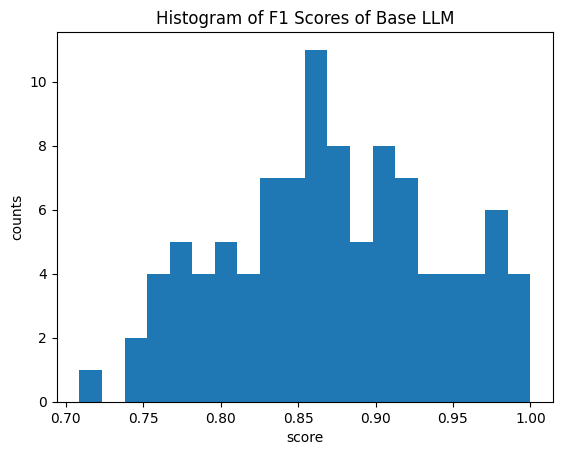

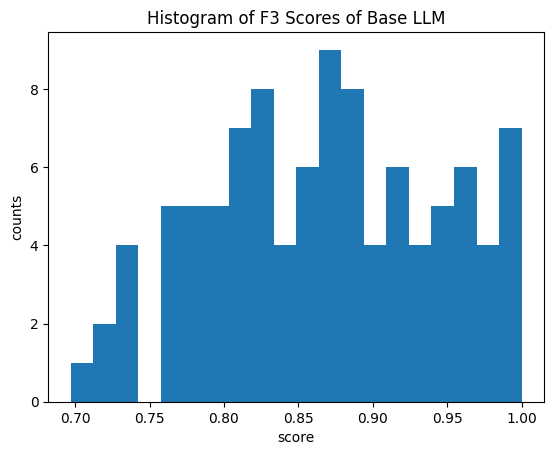

In [11]:
# Calculate score
P_base, R_base, F1_base, F3_base = score(cands=base_test_outputs, refs=output_field_list, lang='python')

F1_base = np.array(F1_base)
F3_base = np.array(F3_base)
P_base = np.array(P_base)
R_base = np.array(R_base)
print(f"Mean level F1 score of base LLM: {F1_base.mean():.3f}")
print(f"Median level F1 score of base LLM: {np.median(F1_base):.3f}")
print(f"Variance level F1 score of base LLM: {np.var(F1_base):.3f}")
print(f"Standard deviation level F1 score of base LLM: {np.std(F1_base):.3f}")
print("------------------")
print(f"Mean level F3 score of base LLM: {F3_base.mean():.3f}")
print(f"Median level F3 score of base LLM: {np.median(F3_base):.3f}")
print(f"Variance level F3 score of base LLM: {np.var(F3_base):.3f}")
print(f"Standard deviation level F3 score of base LLM: {np.std(F3_base):.3f}")

plt.hist(F1_base, bins=20)
plt.title("Histogram of F1 Scores of Base LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

plt.hist(F3_base, bins=20)
plt.title("Histogram of F3 Scores of Base LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

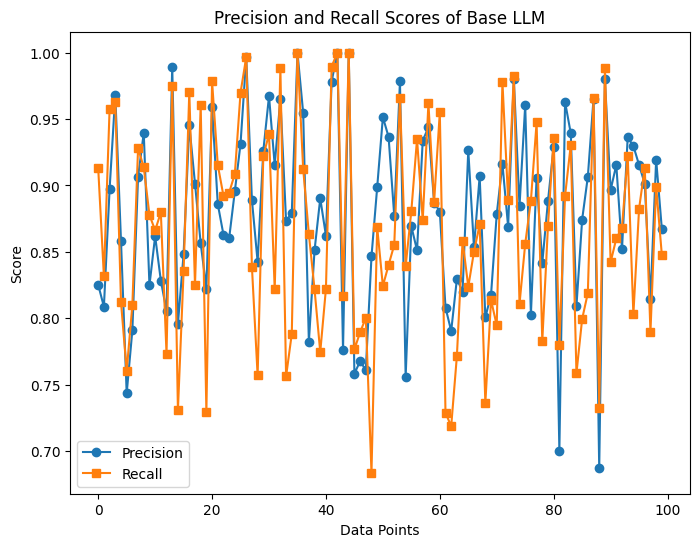

In [12]:
plt.figure(figsize=(8, 6))

# Plot precision and recall
plt.plot(P_base, label='Precision', marker='o')
plt.plot(R_base, label='Recall', marker='s')

# Add labels and title
plt.xlabel('Data Points')
plt.ylabel('Score')
plt.title('Precision and Recall Scores of Base LLM')

# Add legend
plt.legend()

# Display the plot
plt.show()

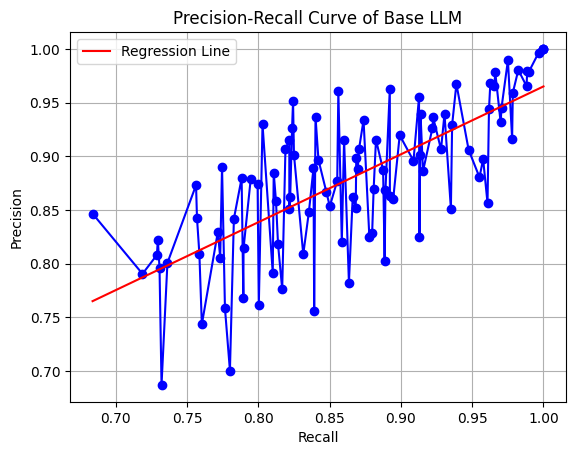

Slope: 0.632
Intercept: 0.333


In [14]:
# Create a sorted array based on recall (inverse_recall)
sorted_indices = np.argsort(R_base)
sorted_recall = R_base[sorted_indices]
sorted_precision = P_base[sorted_indices]

# Create the plot
plt.grid(True)
plt.plot(sorted_recall, sorted_precision, marker='o', color='b')

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve of Base LLM")

# Regress a line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(sorted_recall, sorted_precision)
x_reg = np.linspace(sorted_recall.min(), sorted_recall.max(), 100)
y_reg = slope * x_reg + intercept

plt.plot(x_reg, y_reg, color='r', label='Regression Line')

plt.legend()

# Show the plot
plt.show()

print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")

**Test the supervised fine-tuned LLM model with codeBERT score**




In [15]:
current_output = 0

# Generate outputs for the test dataset
is_load_from_local = True
supervised_test_outputs = []

if is_load_from_local == True:
  drive.mount('/content/drive')

  file_path = '/content/drive/My Drive/fine_tune_data_utils/STF_model_test_output.json'

  with open(file_path, 'r') as f:
    data = json.load(f)

  supervised_test_outputs = data
else:
  supervised_test_outputs = generate_outputs(chosen_dataset, supervised_model, tokenizer)

print(supervised_test_outputs[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
def sum_sequence(sequence):
    sum = 0
    for i in sequence:
        sum += i
    return sum

sum_sequence([1, 2, 3, 4, 5]) # 15


**Save supervised fine-tuned model output into local device**

In [ ]:
# Save supervised fine-tuned model test ouput
if True:
  drive.mount('/content/drive')

  data = supervised_test_outputs
  filename = 'STF_model_test_output.json'
  with open(filename, 'w') as json_file:
      json.dump(data, json_file, indent=4)

  # Save to Google Drive
  with open('/content/drive/My Drive/fine_tune_data_utils/' + filename, 'w') as f:
      json.dump(data, f, indent=4)

  # Download the file
  # files.download(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Mean level F1 score of supervised fine-tuned LLM: 0.869
Median level F1 score of supervised fine-tuned LLM: 0.869
Variance level F1 score of supervised fine-tuned LLM: 0.005
Standard deviation level F1 score of supervised fine-tuned LLM: 0.071
------------------
Mean level F3 score of supervised fine-tuned LLM: 0.865
Median level F3 score of supervised fine-tuned LLM: 0.863
Variance level F3 score of supervised fine-tuned LLM: 0.006
Standard deviation level F3 score of supervised fine-tuned LLM: 0.078


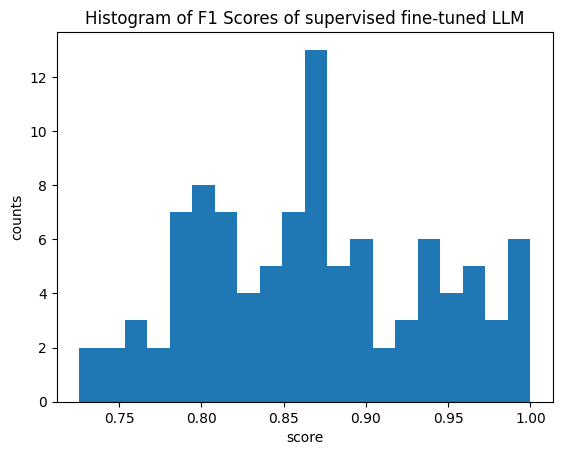

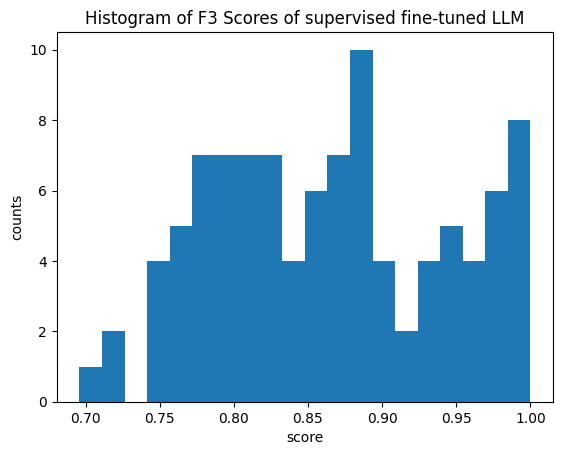

In [16]:
# Calculate score
P_sup, R_sup, F1_sup, F3_sup = score(cands=supervised_test_outputs, refs=output_field_list, lang='python')

F1_sup = np.array(F1_sup)
F3_sup = np.array(F3_sup)
P_sup = np.array(P_sup)
R_sup = np.array(R_sup)
print(f"Mean level F1 score of supervised fine-tuned LLM: {F1_sup.mean():.3f}")
print(f"Median level F1 score of supervised fine-tuned LLM: {np.median(F1_sup):.3f}")
print(f"Variance level F1 score of supervised fine-tuned LLM: {np.var(F1_sup):.3f}")
print(f"Standard deviation level F1 score of supervised fine-tuned LLM: {np.std(F1_sup):.3f}")
print("------------------")
print(f"Mean level F3 score of supervised fine-tuned LLM: {F3_sup.mean():.3f}")
print(f"Median level F3 score of supervised fine-tuned LLM: {np.median(F3_sup):.3f}")
print(f"Variance level F3 score of supervised fine-tuned LLM: {np.var(F3_sup):.3f}")
print(f"Standard deviation level F3 score of supervised fine-tuned LLM: {np.std(F3_sup):.3f}")

plt.hist(F1_sup, bins=20)
plt.title("Histogram of F1 Scores of supervised fine-tuned LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

plt.hist(F3_sup, bins=20)
plt.title("Histogram of F3 Scores of supervised fine-tuned LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

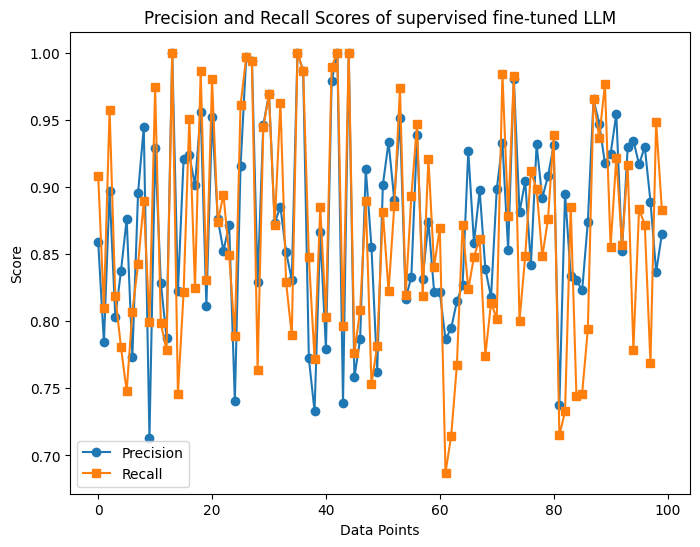

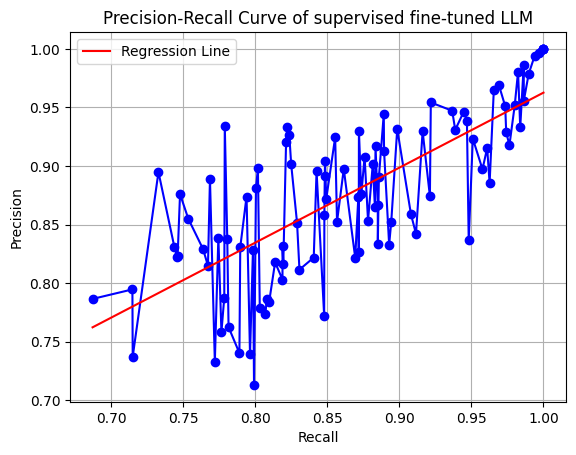

Slope: 0.640
Intercept: 0.322


In [17]:
plt.figure(figsize=(8, 6))

# Plot precision and recall
plt.plot(P_sup, label='Precision', marker='o')
plt.plot(R_sup, label='Recall', marker='s')

# Add labels and title
plt.xlabel('Data Points')
plt.ylabel('Score')
plt.title('Precision and Recall Scores of supervised fine-tuned LLM')

# Add legend
plt.legend()

# Display the plot
plt.show()

# Create a sorted array based on recall (inverse_recall)
sorted_indices = np.argsort(R_sup)
sorted_recall = R_sup[sorted_indices]
sorted_precision = P_sup[sorted_indices]

# Create the plot
plt.grid(True)
plt.plot(sorted_recall, sorted_precision, marker='o', color='b')

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve of supervised fine-tuned LLM")

# Regress a line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(sorted_recall, sorted_precision)
x_reg = np.linspace(sorted_recall.min(), sorted_recall.max(), 100)
y_reg = slope * x_reg + intercept

plt.plot(x_reg, y_reg, color='r', label='Regression Line')

plt.legend()

# Show the plot
plt.show()

print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")

**Test the base LLM model with BERT score**

In [18]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.4 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 9.30 seconds, 10.75 sentences/sec
Mean level F1 score of base LLM: 0.912
Median level F1 score of base LLM: 0.910
Variance level F1 score of base LLM: 0.002
Standard deviation level F1 score of base LLM: 0.044


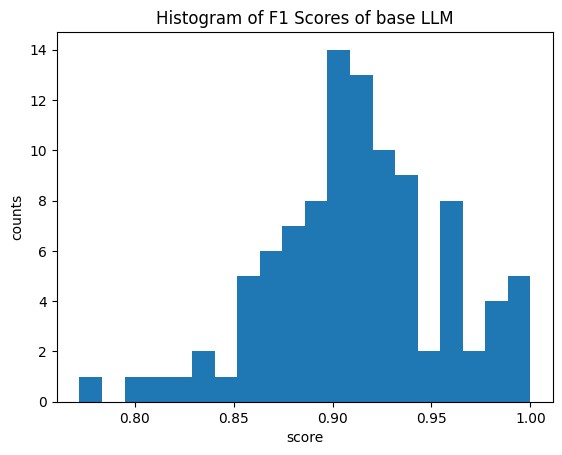

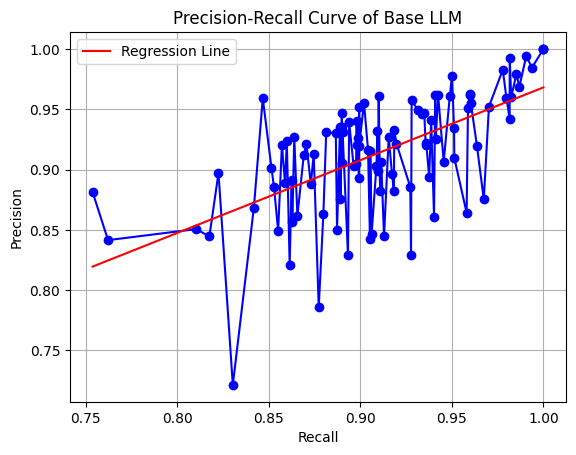

Slope: 0.603
Intercept: 0.365


In [19]:
from bert_score import score

P_base, R_base, F1_base = score(cands=base_test_outputs, refs=output_field_list, lang='en', verbose=True)

F1_base = np.array(F1_base)
P_base = np.array(P_base)
R_base = np.array(R_base)
print(f"Mean level F1 score of base LLM: {F1_base.mean():.3f}")
print(f"Median level F1 score of base LLM: {np.median(F1_base):.3f}")
print(f"Variance level F1 score of base LLM: {np.var(F1_base):.3f}")
print(f"Standard deviation level F1 score of base LLM: {np.std(F1_base):.3f}")

plt.hist(F1_base, bins=20)
plt.title("Histogram of F1 Scores of base LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

# Create a sorted array based on recall (inverse_recall)
sorted_indices = np.argsort(R_base)
sorted_recall = R_base[sorted_indices]
sorted_precision = P_base[sorted_indices]

# Create the plot
plt.grid(True)
plt.plot(sorted_recall, sorted_precision, marker='o', color='b')

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve of Base LLM")

# Regress a line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(sorted_recall, sorted_precision)
x_reg = np.linspace(sorted_recall.min(), sorted_recall.max(), 100)
y_reg = slope * x_reg + intercept

plt.plot(x_reg, y_reg, color='r', label='Regression Line')

plt.legend()

# Show the plot
plt.show()

print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")

**Test the supervised fine-tuned LLM model with BERT score**


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 8.83 seconds, 11.32 sentences/sec
Mean level F1 score of supervised fine-tuned LLM: 0.912
Median level F1 score of supervised fine-tuned LLM: 0.914
Variance level F1 score of supervised fine-tuned LLM: 0.002
Standard deviation level F1 score of supervised fine-tuned LLM: 0.044


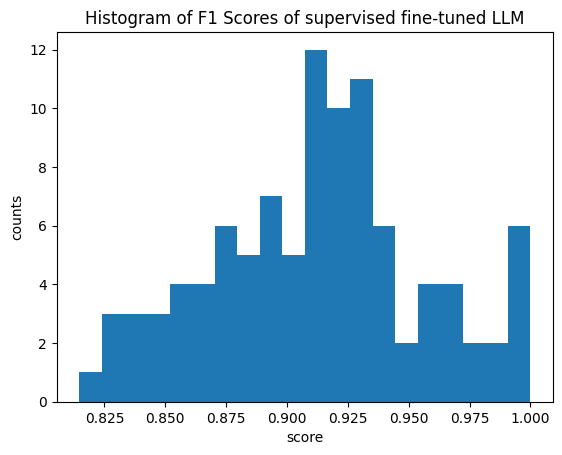

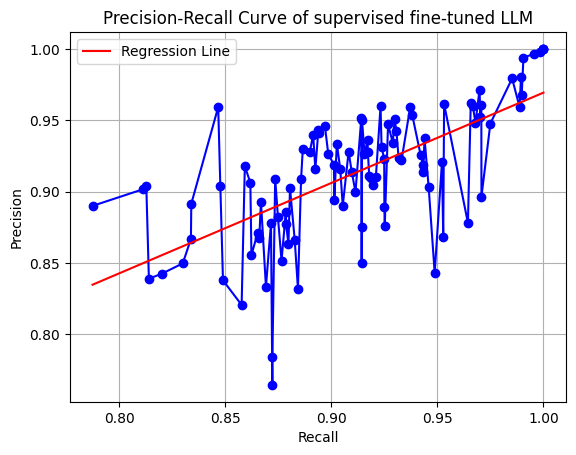

Slope: 0.634
Intercept: 0.335


In [20]:
P_sup, R_sup, F1_sup = score(cands=supervised_test_outputs, refs=output_field_list, lang='en', verbose=True)

F1_sup = np.array(F1_sup)
P_sup = np.array(P_sup)
R_sup = np.array(R_sup)
print(f"Mean level F1 score of supervised fine-tuned LLM: {F1_sup.mean():.3f}")
print(f"Median level F1 score of supervised fine-tuned LLM: {np.median(F1_sup):.3f}")
print(f"Variance level F1 score of supervised fine-tuned LLM: {np.var(F1_sup):.3f}")
print(f"Standard deviation level F1 score of supervised fine-tuned LLM: {np.std(F1_sup):.3f}")

plt.hist(F1_sup, bins=20)
plt.title("Histogram of F1 Scores of supervised fine-tuned LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

# Create a sorted array based on recall (inverse_recall)
sorted_indices = np.argsort(R_sup)
sorted_recall = R_sup[sorted_indices]
sorted_precision = P_sup[sorted_indices]

# Create the plot
plt.grid(True)
plt.plot(sorted_recall, sorted_precision, marker='o', color='b')

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve of supervised fine-tuned LLM")

# Regress a line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(sorted_recall, sorted_precision)
x_reg = np.linspace(sorted_recall.min(), sorted_recall.max(), 100)
y_reg = slope * x_reg + intercept

plt.plot(x_reg, y_reg, color='r', label='Regression Line')

plt.legend()

# Show the plot
plt.show()

print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")

**Test the base and supervised fine-tuned LLM model with BLEU score**

In [ ]:
!pip install nltk

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Mean BLEU score of base LLM: 0.231
Median BLEU score of base LLM: 0.101
Variance BLEU score of base LLM: 0.083
Standard deviation BLEU score of base LLM: 0.288


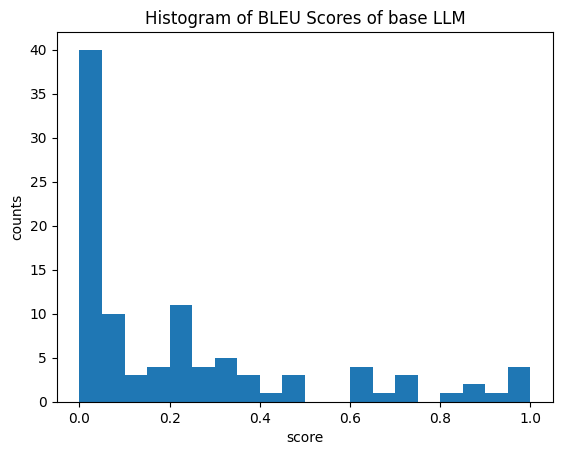

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

references = []

for item in output_field_list:
  references.append([item.split()])

BLEU_base = []

for i in range(len(base_test_outputs)):
    score = sentence_bleu(references[i], base_test_outputs[i].split())
    BLEU_base.append(score)

BLEU_base = np.array(BLEU_base)

print(f"Mean BLEU score of base LLM: {BLEU_base.mean():.3f}")
print(f"Median BLEU score of base LLM: {np.median(BLEU_base):.3f}")
print(f"Variance BLEU score of base LLM: {np.var(BLEU_base):.3f}")
print(f"Standard deviation BLEU score of base LLM: {np.std(BLEU_base):.3f}")

plt.hist(BLEU_base, bins=20)
plt.title("Histogram of BLEU Scores of base LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

Mean BLEU score of supervised fine-tuned LLM: 0.227
Median BLEU score of supervised fine-tuned LLM: 0.117
Variance BLEU score of supervised fine-tuned LLM: 0.087
Standard deviation BLEU score of supervised fine-tuned LLM: 0.295


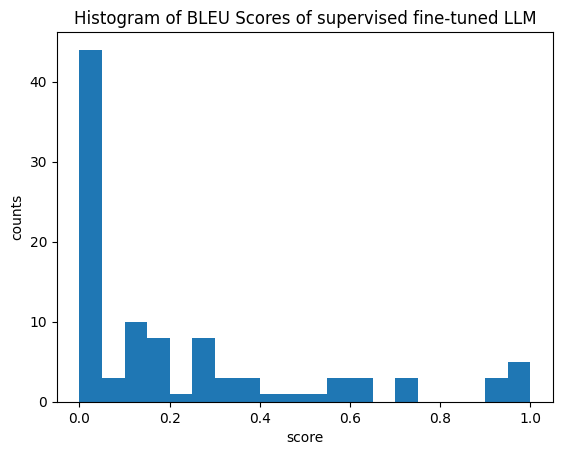

In [ ]:
BLEU_sup = []

for i in range(len(supervised_test_outputs)):
    score = sentence_bleu(references[i], supervised_test_outputs[i].split())
    BLEU_sup.append(score)

BLEU_sup = np.array(BLEU_sup)

print(f"Mean BLEU score of supervised fine-tuned LLM: {BLEU_sup.mean():.3f}")
print(f"Median BLEU score of supervised fine-tuned LLM: {np.median(BLEU_sup):.3f}")
print(f"Variance BLEU score of supervised fine-tuned LLM: {np.var(BLEU_sup):.3f}")
print(f"Standard deviation BLEU score of supervised fine-tuned LLM: {np.std(BLEU_sup):.3f}")

plt.hist(BLEU_sup, bins=20)
plt.title("Histogram of BLEU Scores of supervised fine-tuned LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

**Test the base and supervised fine-tuned LLM model with codeBLEU score**

In [ ]:
!pip install codebleu
!pip install tree-sitter-python==0.21

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.6/542.6 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 11.5 MB/s eta 0:00:00


In [ ]:
from codebleu import calc_codebleu

code_BLEU_results_base = calc_codebleu(output_field_list, base_test_outputs, lang="python", weights=(0.25, 0.25, 0.25, 0.25))
code_BLEU_base = code_BLEU_results_base['codebleu']

print(f"codeBLEU score of base LLM: {code_BLEU_base:.3f}")

codeBLEU score of base LLM: 0.315


In [ ]:
code_BLEU_results_sup = calc_codebleu(supervised_test_outputs, output_field_list, lang="python", weights=(0.25, 0.25, 0.25, 0.25))

code_BLEU_sup = code_BLEU_results_sup['codebleu']

print(f"codeBLEU score of supervised fine-tuned LLM: {code_BLEU_sup:.3f}")

codeBLEU score of supervised fine-tuned LLM: 0.341
